# Assemble image pathnames and understand class breakdown in dataset

In [1]:
import numpy as np
from glob import glob
import torch

# Note down train, validation and test directories.
train_dir = "data/train"
valid_dir = "data/valid"
test_dir = "data/test"

# Check quantities of train, validation and test images
train_images = np.array(glob("data/train/*/*"))
valid_images = np.array(glob("data/valid/*/*"))
test_images = np.array(glob("data/test/*/*"))

# Check relative percentages of image types
train_images_mel = np.array(glob("data/train/melanoma/*"))
train_images_nev = np.array(glob("data/train/nevus/*"))
train_images_seb = np.array(glob("data/train/seborrheic_keratosis/*"))

valid_images_mel = np.array(glob("data/valid/melanoma/*"))
valid_images_nev = np.array(glob("data/valid/nevus/*"))
valid_images_seb = np.array(glob("data/valid/seborrheic_keratosis/*"))

test_images_mel = np.array(glob("data/test/melanoma/*"))
test_images_nev = np.array(glob("data/test/nevus/*"))
test_images_seb = np.array(glob("data/test/seborrheic_keratosis/*"))

num_train_images = len(train_images)
num_valid_images = len(valid_images)
num_test_images = len(test_images)

print("There are {} training images, {} validation images and {} test images.".format(len(train_images),len(valid_images),len(test_images)))
print("For the training images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(train_images_mel)/len(train_images)*100, mel2=len(train_images_mel),nev=len(train_images_nev)/len(train_images)*100, nev2=len(train_images_nev), seb=len(train_images_seb)/len(train_images)*100, seb2=len(train_images_seb)))
print("For the validation images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(valid_images_mel)/len(valid_images)*100, mel2=len(valid_images_mel),nev=len(valid_images_nev)/len(valid_images)*100, nev2=len(valid_images_nev), seb=len(valid_images_seb)/len(valid_images)*100, seb2=len(valid_images_seb)))
print("For the test images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(test_images_mel)/len(test_images)*100, mel2=len(test_images_mel),nev=len(test_images_nev)/len(test_images)*100, nev2=len(test_images_nev), seb=len(test_images_seb)/len(test_images)*100, seb2=len(test_images_seb)))

There are 2000 training images, 150 validation images and 600 test images.
For the training images, 18.7% (374) are of melanoma, 68.6% (1372) are of nevus and 12.7% (254) are for seborrheic keratosis.
For the validation images, 20.0% (30) are of melanoma, 52.0% (78) are of nevus and 28.0% (42) are for seborrheic keratosis.
For the test images, 19.5% (117) are of melanoma, 65.5% (393) are of nevus and 15.0% (90) are for seborrheic keratosis.


In [2]:
# Check for GPU support
use_cuda = torch.cuda.is_available()

In [3]:
# Check to see how many GPUs are available.
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    num_devices = torch.cuda.device_count()
    print("{} GPUs found.".format(num_devices))
else:
    num_devices = 0

8 GPUs found.


# View random images to get a feel for what the dataset looks like

In [4]:
from ISIC2017_with_optimization.helper import plot_some_imgs
%matplotlib inline 

Plotting 10 images from dataset /data/train/melanoma


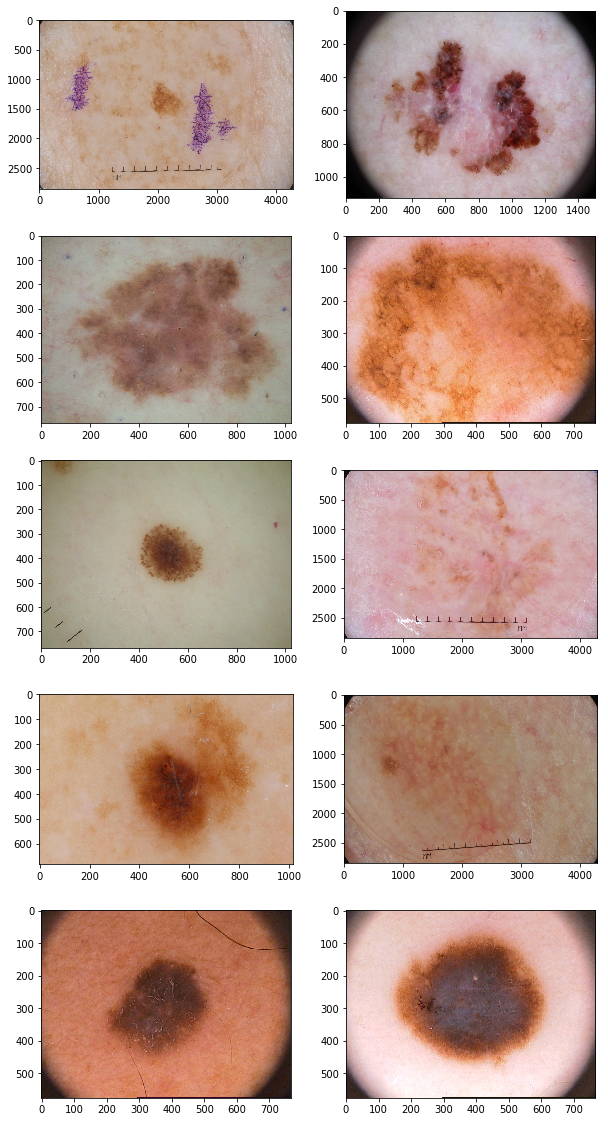

In [5]:
plot_some_imgs(10,train_images_mel,'/data/train/melanoma')

# Imports and model setup

In [6]:
# Decide whether or not to use DALI.
use_dali = 1

In [7]:
# First take care of Pytorch imports
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

# NVIDIA DALI imports.
if use_dali:
    from nvidia.dali.pipeline import Pipeline
    import nvidia.dali.ops as ops
    import nvidia.dali.types as types
    from nvidia.dali.plugin.pytorch import DALIGenericIterator
    from ISIC2017_with_optimization.helper import view_DALIiter_images, ExternalInputIterator

# Now handle imports needed for HPBANDSTER.
import os, sys
import time
from random import shuffle
import pickle
import argparse
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from hpbandster.core.worker import Worker
import logging
logging.basicConfig(level=logging.DEBUG)

In [8]:
# Build a pretrained Alexnet that is compatible with both the ISIC dataset (3 output classes) and the HPBANDSTER optimization package.
# Note that it is possible to even iterate over the network architecture, but the default is not to do so.

def ISICNetAlex(num_new_fc_layers=0, new_layer_elements=[], dropout_rate=0.5, old_fclayers_tofreeze=[0,1]):
    # num_new_fc_layers -- There are 3 FC layers in Alexnet to begin with. The last layer gets replaced by default. 
    #                      A value of 1 here would add a fourth layer, whereas a value of 0 would just retool the last layer.
    # dropout_rate --      0<= dropout_rate < 1. Sets the dropout rate for each FC layer to this .value.
    # old_fclayers_to_freeze --  A set of indices with length <= 2. Must be a subset of [0,1]
    model = models.alexnet(pretrained=True)
    num_output_nodes = 3
    # Set these three params even though they're passed into the function because in this notebook I'm only looking at dropout and learning rate. 
    num_new_fc_layers = 0
    new_layer_elements = []
    old_fclayers_tofreeze = []
    
    # Input error checking
    
    # Can't have negative number of new layers.
    assert num_new_fc_layers >= 0
    # Dropout rate must be between 0 and 1
    assert 0 <= dropout_rate < 1
    # You have to specify the number of output elements for each additional layer you want.
    assert num_new_fc_layers == len(new_layer_elements)
    # Old layers to freeze must be picked from the following: [0,1]. All new layers and the last layer will be trained by necessity.
    checklayers = set(old_fclayers_tofreeze)
    assert checklayers.issubset([0,1])
    
    # Add the new layers. This will have the same structure as the existing fc layers.
    for i in range(num_new_fc_layers+1):
        # No dropout before the last layer.
        if i == num_new_fc_layers:
            model.classifier.add_module(str(6+i*3), nn.ReLU(inplace=True))
            model.classifier.add_module(str(6+i*3), nn.Linear(model.classifier[4+i*3].out_features,num_output_nodes,bias=True))
        else:
            model.classifier.add_module(str(6+i*3), nn.Dropout(dropout_rate))
            model.classifier.add_module(str(7+i*3), nn.Linear(model.classifier[7+(i-1)*3].out_features,new_layer_elements[i],bias=True))
            model.classifier.add_module(str(8+i*3), nn.ReLU(inplace=True))
            
             
    # Set requires_grad appropriately for the model.
    # First, set all requires_grad for all parameters in the features portion of the model to False.
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Now deal with the classifier.
    for i in range(len(old_fclayers_tofreeze)):
        if old_fclayers_tofreeze[i] == 0:
            for param in model.classifier[0].parameters():
                param.requires_grad = False
            for param in model.classifier[1].parameters():
                param.requires_grad = False
            for param in model.classifier[2].parameters():
                param.requires_grad = False
        if old_fclayers_tofreeze[i] == 1:
            for param in model.classifier[3].parameters():
                param.requires_grad = False
            for param in model.classifier[4].parameters():
                param.requires_grad = False
            for param in model.classifier[5].parameters():
                param.requires_grad = False
    
    #set dropout rate for all relevant layers.
    for i in range(len(model.classifier)):
        if type(model.classifier[i]) is torch.nn.modules.dropout.Dropout:
            model.classifier[i] = nn.Dropout(dropout_rate)

    # Print the model
    print(model)
        
    return model

In [9]:
# Get the number of parameters to be tuned in the model.

def number_of_parameters(model):
        return(sum(p.numel() for p in model.module.parameters() if p.requires_grad))

# Define image processing pipelines

In [10]:
# Define the image processing pipeline for processing training.
# If reproducibility is desired, on the input to super(TrainingPipeline, self), set seed = some # other than -1. 
# Note that for all of these, a global iterator is required (i.e. the iterator 'iter_train' can't be local to the TrainPipeline)
# Not sure why this has to be the case yet, but we'll get there.
# TODO -- see about making iterator local to the class.

if use_dali:

    class TrainPipeline(Pipeline):
        def __init__(self, batch_size, num_threads, device_id, image_dir):
            super(TrainPipeline, self).__init__(batch_size, num_threads, device_id)
            self.input = ops.ExternalSource()
            self.input_label = ops.ExternalSource()
            self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
            self.resize = ops.Resize(device="gpu")
            self.resize_rng = ops.Uniform(range = (256,512))
            self.crop = ops.Crop(device="gpu", crop=(224,224))
            self.rotate = ops.Rotate(device="gpu") # Need to specify angle
            self.angle_rng = ops.Uniform(range = (-45.0,45.0))
            self.coin = ops.CoinFlip(probability=0.5)
            self.vertflip = ops.Flip(device="gpu", vertical=1)
            self.horizflip = ops.Flip(device="gpu")
            self.norm = ops.NormalizePermute(device = "gpu",
                                            height = 224,
                                            width = 224,
                                            mean = [123.675, 116.28, 103.53],
                                            std = [58.395, 57.12, 57.375])

        def define_graph(self):
            self.jpegs = self.input()
            self.labels = self.input_label()
            images = self.decode(self.jpegs)
            images = self.resize(images, resize_shorter=self.resize_rng())
            images = self.crop(images)
            images = self.vertflip(images, mask=self.coin())
            images = self.rotate(images, angle = self.angle_rng(), mask = self.coin())
            images = self.horizflip(images, mask=self.coin())
            images = self.norm(images)
            return (images, self.labels)

        def iter_setup(self):
            (images, labels) = iter_train.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)

In [11]:
# Define the image processing pipeline for validation.
# If reproducibility is desired, on the input to super(ValidPipeline, self), set seed = some # other than -1. 

if use_dali:

    class ValidPipeline(Pipeline):
        def __init__(self, batch_size, num_threads, device_id, image_dir):
            super(ValidPipeline, self).__init__(batch_size, num_threads, device_id)
            self.input = ops.ExternalSource()
            self.input_label = ops.ExternalSource()
            self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
            self.resize = ops.Resize(device="gpu")
            self.resize_rng = ops.Uniform(range = (224,224))
            self.crop = ops.Crop(device="gpu", crop=(224,224))
            self.norm = ops.NormalizePermute(device = "gpu",
                                            height = 224,
                                            width = 224,
                                            mean = [123.675, 116.28, 103.53],
                                            std = [58.395, 57.12, 57.375])

        def define_graph(self):
            self.jpegs = self.input()
            self.labels = self.input_label()
            images = self.decode(self.jpegs)
            images = self.resize(images, resize_shorter=self.resize_rng())
            images = self.crop(images)
            images = self.norm(images)
            return (images, self.labels)

        def iter_setup(self):
            (images, labels) = iter_valid.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)

In [12]:
# Define the image processing pipeline for test.
# If reproducibility is desired, on the input to super(ValidPipeline, self), set seed = some # other than -1. 

if use_dali:
    class TestPipeline(Pipeline):
        def __init__(self, batch_size, num_threads, device_id, image_dir):
            super(TestPipeline, self).__init__(batch_size, num_threads, device_id)
            self.input = ops.ExternalSource()
            self.input_label = ops.ExternalSource()
            self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
            self.resize = ops.Resize(device="gpu")
            self.resize_rng = ops.Uniform(range = (224,224))
            self.crop = ops.Crop(device="gpu", crop=(224,224))
            self.norm = ops.NormalizePermute(device = "gpu",
                                            height = 224,
                                            width = 224,
                                            mean = [123.675, 116.28, 103.53],
                                            std = [58.395, 57.12, 57.375])

        def define_graph(self):
            self.jpegs = self.input()
            self.labels = self.input_label()
            images = self.decode(self.jpegs)
            images = self.resize(images, resize_shorter=self.resize_rng())
            images = self.crop(images)
            images = self.norm(images)
            return (images, self.labels)

        def iter_setup(self):
            (images, labels) = iter_test.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)

In [13]:
# Functions to build the data loaders using NVIDIA DALI if GPUs are available and Pytorch if not.

def setup_dali_iterators(train_batch, valid_batch, test_batch):
    # Loaders
    train_dir = 'data/train'
    valid_dir = 'data/valid'
    test_dir =  'data/test'
    # Build the iterators. 
    eii_train = ExternalInputIterator(batch_size=train_batch, image_dir=train_dir, shuffle_flag=True)
    iter_train = iter(eii_train)

    eii_valid = ExternalInputIterator(batch_size=valid_batch, image_dir=valid_dir, shuffle_flag=False)
    iter_valid = iter(eii_valid)

    eii_test = ExternalInputIterator(batch_size=test_batch, image_dir=test_dir, shuffle_flag=False)
    iter_test = iter(eii_test)
    
    return iter_train, iter_valid, iter_test
    
def setup_data_loader(num_devices, use_dali, train_batch, valid_batch, test_batch, iter_train, iter_valid, iter_test):
    if num_devices > 0 and use_dali:
        # GPUs
        N = num_devices
        # Loaders
        train_dir = 'data/train'
        valid_dir = 'data/valid'
        test_dir =  'data/test'

        # Training loader
        pipe_t =  [TrainPipeline, (0, 2)]

        pipe_name, label_range = pipe_t
        print ("RUN: "  + pipe_name.__name__)
        pipes = [pipe_name(batch_size=train_batch, num_threads=2, device_id = device_id, image_dir = train_dir) for device_id in range(N)]

        train_loader = DALIGenericIterator(pipes, ['data', 'label'], num_train_images, stop_at_epoch = False)

        # Validation loader.
        pipe_v =  [ValidPipeline, (0, 2)]

        pipe_name, label_range = pipe_v
        print ("RUN: "  + pipe_name.__name__)        
        pipes = [pipe_name(batch_size=valid_batch, num_threads=2, device_id = device_id, image_dir = valid_dir) for device_id in range(N)]

        valid_loader = DALIGenericIterator(pipes, ['data', 'label'], num_valid_images)

        # Test loader.
        pipe_ts =  [TestPipeline, (0, 2)]

        pipe_name, label_range = pipe_ts
        print ("RUN: "  + pipe_name.__name__)
        pipes = [pipe_name(batch_size=test_batch, num_threads=2, device_id = device_id, image_dir = test_dir) for device_id in range(N)]

        test_loader = DALIGenericIterator(pipes, ['data', 'label'], num_test_images)

    # If no GPUs are available, just use Pytorch's built-in data loading functions. Note that pinning memory is 
    # not necessary if there are no GPUs. 
    if num_devices == 0 and not use_dali:
        random_transforms = [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomAffine(degrees=45,translate=(0.1,0.3),scale=(0.5,2))]

        train_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.RandomChoice(random_transforms), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])

        valid_test_transforms = transforms.Compose([transforms.Resize(size=224),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])


        # No data augmentation for the validation and test datasets, because we're using those as is for evaluation.
        train_data = datasets.ImageFolder('data/train',transform=train_transforms)
        validation_data = datasets.ImageFolder('data/valid',transform=valid_test_transforms)
        test_data = datasets.ImageFolder('data/test',transform=valid_test_transforms)

        batch_size = 128
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True, num_workers=4)

        valid_loader = torch.utils.data.DataLoader(validation_data, num_workers=4)
        test_loader = torch.utils.data.DataLoader(test_data, num_workers=4)
    elif num_devices > 0 and not use_dali:
        random_transforms = [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomAffine(degrees=45,translate=(0.1,0.3),scale=(0.5,2))]

        train_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.RandomChoice(random_transforms), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])

        valid_test_transforms = transforms.Compose([transforms.Resize(size=224),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])


        # No data augmentation for the validation and test datasets, because we're using those as is for evaluation.
        train_data = datasets.ImageFolder('data/train',transform=train_transforms)
        validation_data = datasets.ImageFolder('data/valid',transform=valid_test_transforms)
        test_data = datasets.ImageFolder('data/test',transform=valid_test_transforms)

        batch_size = 128
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True, num_workers=num_devices*4, pin_memory=True)

        valid_loader = torch.utils.data.DataLoader(validation_data, batch_size = 16, num_workers=num_devices*4, pin_memory=True)
        test_loader = torch.utils.data.DataLoader(test_data, num_workers=num_devices*4, pin_memory=True)

    return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [14]:
# Build the processing pipelines.

if use_dali:
    iter_train, iter_valid, iter_test = setup_dali_iterators(16, 2, 5)
else:
    iter_train = []
    iter_valid = []
    iter_test = []
loader_dict = setup_data_loader(num_devices, use_dali, 16, 2, 5, iter_train, iter_valid, iter_test)

RUN: TrainPipeline
RUN: ValidPipeline
RUN: TestPipeline


# Setup HpBandSter flow.

In [18]:
# Define the worker
class worker(Worker):
    def __init__(self, N_train = 200, N_valid = len(valid_images), **kwargs):
            super().__init__(**kwargs)          
                    
    def compute(self, config, budget, working_directory, *args, **kwargs):
        """
        The input parameter "config" (dictionary) contains the sampled configurations passed by the bohb optimizer
        """
        """ The below is how you would set things up if you wanted to modify the network architecture."""
        #new_layer_elements = np.array([config['num_els_new_1'] if config['num_new_fc_layers'] >= 1 else None, 
        #                      config['num_els_new_2'] if config['num_new_fc_layers'] >= 2 else None, 
        #                      config['num_els_new_3'] if config['num_new_fc_layers'] >= 3 else None])
        
        #new_layer_elements = list(new_layer_elements[new_layer_elements != None])
        
        #old_fclayers_tofreeze = np.array([0 if config['freeze0_cat'] == 1 else None,
        #                        1 if config['freeze1_cat'] == 1 else None])
        
        #old_fclayers_tofreeze = list(old_fclayers_tofreeze[old_fclayers_tofreeze != None])
        
        
        # Generate the model.
        model = ISICNetAlex(num_new_fc_layers=0,
                                                new_layer_elements=[],
                                                dropout_rate=config['dropout_rate'],
                                                old_fclayers_tofreeze=[],
        )
        
        # Make a DataParallel model if there are multiple GPUs available. 
        if num_devices > 1:
            model = nn.DataParallel(model)
            
        # Build criterion and optimizer.
        # When using DALI, it is essential to set the reduction='sum' flag when using CrossEntropyLoss.
        # Because of the way that DALI queues up images into the processing pipeline, failing to use reduction='sum' will yield different
        # losses on the same dataset using the same model, even when not shuffling the images in the dataset! This is due to an adverse
        # interaction between the way the DALI iterator works and how PyTorch calculates Cross Entropy Loss when _reduction_ is not set to 'sum'
        #
        # It is not necessary to set reduction='sum' when using the PyTorch iterators, but it won't hurt either.
        criterion = nn.CrossEntropyLoss(reduction='sum')
        
        if num_devices > 0:
            optimizer = optim.SGD(model.module.parameters(), lr = config['lr'], momentum=config['sgd_momentum'])
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])
        
        # Example of how to switch optimizers depending on what the config is. The below would need to be modified to use DALI.
        #if config['optimizer'] == 'Adam':
        #    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
        #else:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])
        
        # Send the model to GPU (or keep it on the CPU, depending on what is available)
        model.to(device);
        
        
        # Run training loop
        for epoch in range(1,int(budget)+1):
            start = time.time()
            # initialize variables to monitor training and validation loss
            train_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()
            num_imgs_sofar = 0
            
            if use_dali:
                for batch_idx , batch_data in enumerate(loader_dict['train']):
                    # move to GPU
                    data = torch.stack([image for gpu_batch in batch_data for image in gpu_batch['data']])
                    target = torch.stack([label.to(torch.long) for gpu_batch in batch_data for label in gpu_batch['label']])[:,0]
                    optimizer.zero_grad()
                    output = model.forward(data)
                    loss = criterion(output.cpu(), target)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.data
                    num_imgs_sofar += len(target)
                loader_dict['train'].reset()
            else: 
                for batch_idx, (data, target) in enumerate(loader_dict['train']):
                    # move to GPU or do nothing, if no GPUs
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    ## update the average validation loss
                    output = model.forward(data)
                    loss = criterion(output,target)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.data
                    num_imgs_sofar += len(target)

            print("Epoch {} training time took {} seconds".format(epoch,time.time()-start))

        train_accuracy = self.evaluate_accuracy(model, loader_dict['train'])
        validation_accuracy = self.evaluate_accuracy(model, loader_dict['valid'])
        test_accuracy = self.evaluate_accuracy(model, loader_dict['test'])

        return ({
                'loss': 1-validation_accuracy, # remember: HpBandSter always minimizes!
                'info': {       'test accuracy': test_accuracy,
                                        'train accuracy': train_accuracy,
                                        'validation accuracy': validation_accuracy,
                                        'number of parameters': number_of_parameters(model),
                                }

        })

    def evaluate_accuracy(self, model, data_loader):
        correct = 0
        total = 0
        model.eval()
        if use_dali:
            for batch_idx , batch_data in enumerate(data_loader):
                # move to GPU
                data = torch.stack([image for gpu_batch in batch_data for image in gpu_batch['data']])
                target = torch.stack([label.to(torch.long) for gpu_batch in batch_data for label in gpu_batch['label']])[:,0]
                output = model.forward(data)
                pred = output.cpu().data.max(1, keepdim=True)[1]
                correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).numpy())
                total += data.size(0)
            data_loader.reset()
        else: 
            for batch_idx, (data, target) in enumerate(data_loader):
                # move to GPU or do nothing, if no GPUs
                data, target = data.to(device), target.to(device)
                ## update the average validation loss
                output = model.forward(data)
                pred = output.data.max(1, keepdim=True)[1]
                # compare predictions to true label
                correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
                total += data.size(0)

        #import pdb; pdb.set_trace()
        return(correct/total)


    @staticmethod
    def get_configspace():
        """
        It builds the configuration space with the needed hyperparameters.
        It is easily possible to implement different types of hyperparameters.
        Beside float-hyperparameters on a log scale, it is also able to handle categorical input parameter.
        :return: ConfigurationsSpace-Object
        """
        cs = CS.ConfigurationSpace()

        # Training batch size hyperparameter
        #batchsize = CSH.UniformIntegerHyperparameter('train_batch_size', lower=1, upper=128, default_value=32,log=True)

        # Learning rate hyperparameter
        lr = CSH.UniformFloatHyperparameter('lr', lower=1e-6, upper=1e-1, default_value='1e-2', log=True)

        # Optimizer hyperparameter.
        #optimizer = CSH.CategoricalHyperparameter('optimizer', ['Adam', 'SGD'])

        # Stochastic gradient descent momentum as parameter.
        sgd_momentum = CSH.UniformFloatHyperparameter('sgd_momentum', lower=0.0, upper=0.99, default_value=0.9, log=False)

        cs.add_hyperparameters([lr, sgd_momentum])
        #cs.add_hyperparameters([optimizer])

        # Only add the sgd_momentum hyperparameter if the optimizer is stochastic gradient descent. Otherwise, it doesn't make sense.
        #cond = CS.EqualsCondition(sgd_momentum, optimizer, 'SGD')
        #cs.add_condition(cond)


        #num_new_fc_layers =  CSH.UniformIntegerHyperparameter('num_new_fc_layers', lower=0, upper=3, default_value=0, log=False)
        #num_els_new_1 = CSH.UniformIntegerHyperparameter('num_els_new_1', lower=128, upper=4096, default_value = 1000, log=True)
        #num_els_new_2 = CSH.UniformIntegerHyperparameter('num_els_new_2', lower=128, upper=4096, default_value = 1000, log=True)
        #num_els_new_3 = CSH.UniformIntegerHyperparameter('num_els_new_3', lower=128, upper=4096, default_value = 1000, log=True)

        #freeze0_old = CSH.UniformIntegerHyperparameter('freeze0_cat', lower = 0, upper = 1, default_value = 1, log=False)
        #freeze1_old = CSH.UniformIntegerHyperparameter('freeze1_cat', lower=0, upper=1, default_value=1, log=False)

        #cs.add_hyperparameters([num_new_fc_layers, num_els_new_1, num_els_new_2, num_els_new_3, freeze0_old, freeze1_old, batchsize])

        dropout_rate = CSH.UniformFloatHyperparameter('dropout_rate', lower=0.0, upper=0.9, default_value=0.5, log=False)

        cs.add_hyperparameters([dropout_rate])

        return cs





# Set up and perform the run.

In [19]:
# Define the parser
parser = argparse.ArgumentParser(description='ISIC2017 - CNN on Derm Dataset')
parser.add_argument('--min_budget',   type=float, help='Minimum number of epochs for training.',    default=1)
parser.add_argument('--max_budget',   type=float, help='Maximum number of epochs for training.',    default=15)
parser.add_argument('--n_iterations', type=int,   help='Number of iterations performed by the optimizer', default=100)
parser.add_argument('--worker', help='Flag to turn this into a worker process', action='store_true')
parser.add_argument('--run_id', type=str, help='A unique run id for this optimization run. An easy option is to use the job id of the clusters scheduler.')
parser.add_argument('--nic_name',type=str, help='Which network interface to use for communication.', default='lo')
parser.add_argument('--shared_directory',type=str, help='A directory that is accessible for all processes, e.g. a NFS share.', default='/home/ubuntu/src/derm-ai/data')
parser.add_argument('--backend',help='Toggles which worker is used. Choose between a pytorch and a keras implementation.', choices=['pytorch', 'keras'], default='pytorch')
args = parser.parse_args([])

In [20]:
host = hpns.nic_name_to_host(args.nic_name)
# This example shows how to log live results. This is most useful
# for really long runs, where intermediate results could already be
# interesting. The core.result submodule contains the functionality to
# read the two generated files (results.json and configs.json) and
# create a Result object.
result_logger = hpres.json_result_logger(directory=args.shared_directory, overwrite=True)
# Start a nameserver:
NS = hpns.NameServer(run_id=args.run_id, host=host, port=0, working_directory=args.shared_directory)
ns_host, ns_port = NS.start()



In [21]:
# Start local worker
w = worker(run_id=args.run_id, host=host, nameserver=ns_host, nameserver_port=ns_port, timeout=120)
w.run(background=True)

DEBUG:hpbandster.run_None.worker.ip-172-31-47-183.30390:WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7fc66404ddd8; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:37664>
DEBUG:hpbandster.run_None.worker.ip-172-31-47-183.30390:WORKER: No dispatcher found. Waiting for one to initiate contact.
INFO:hpbandster.run_None.worker.ip-172-31-47-183.30390:WORKER: start listening for jobs


In [22]:
bohb = BOHB(  configspace = w.get_configspace(),
                      run_id = args.run_id,
                      host=host,
                      nameserver=ns_host,
                      nameserver_port=ns_port,
                      result_logger=result_logger,
                      min_budget=args.min_budget, max_budget=args.max_budget,
               )

INFO:hpbandster:DISPATCHER: started the 'discover_worker' thread
INFO:hpbandster:DISPATCHER: started the 'job_runner' thread


In [23]:
# Run an optimizer

res = bohb.run(n_iterations=args.n_iterations)
bohb.shutdown(shutdown_workers=True)
NS.shutdown()

DEBUG:hpbandster:wait_for_workers trying to get the condition
INFO:hpbandster:DISPATCHER: Pyro daemon running on 127.0.0.1:36637
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 0 currently in the pool.
INFO:hpbandster:DISPATCHER: discovered new worker, hpbandster.run_None.worker.ip-172-31-47-183.30390140493164119808
DEBUG:hpbandster:HBMASTER: number of workers changed to 1
DEBUG:hpbandster:DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
DEBUG:hpbandster:Enough workers to start this run!
DEBUG:hpbandster:adjust_queue_size: lock accquired
INFO:hpbandster:HBMASTER: starting run at 1546897743.746135
INFO:hpbandster:HBMASTER: adjusted queue size to (0, 1)
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:start sampling a new configuration.
DEBUG:hpbandster:DISPATCHER: Trying to submit another job.
DEBUG:hpbandster:done sampling a new configuration.
DEBUG:hpbandster:DISPATCHER: jobs to

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2581001206508734)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.2581001206508734)
    (4): Linear

KeyboardInterrupt: 